In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers
from sklearn.decomposition import PCA
from sklearn.cluster import *

In [2]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location, 'labelled')

reading outlooks
reading pph
reading storm reports


# Preprocessing

In [4]:
category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}


season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Great Plains': 1,
    'Midwest': 2,
    'Northeast': 3,
    'South': 4
}

tor_dict = {
    'NONE': -1,
    'EFU': 0,
    '(E)F0': 1,
    '(E)F1': 2,
    '(E)F2': 3,
    '(E)F3': 4,
    '(E)F4': 5,
    '(E)F5': 6
}

cats = ['MAX_CAT', 'SEASON', 'TOR_F']
dicts = [category_dict, season_dict, tor_dict]

In [6]:
# remove unneeded variables and x, y dimensions
data = pph.drop(['lat', 'lon', 'p_perfect_wind', 'p_perfect_sig_wind', 'p_perfect_hail', 'p_perfect_sig_hail', 'p_perfect_tor', 'p_perfect_sig_tor', 'RAMP_CAT', 'p_perfect_total', 'p_perfect_max', 'PPH_CAT', 'PPH_NUM', 'PPH_D_CAT', 'WINDSP_CAT', 'HAILSZ_CAT', 'REGION', 'REGION_M'])


# make data numerical
def convert_strings_to_ints(data, conversion_dict):
    return np.vectorize(conversion_dict.get)(data)

for cat, dic in zip(cats, dicts):

    data[cat] = xr.apply_ufunc(
        convert_strings_to_ints,  # function to apply
        data[cat],      # input data
        kwargs={'conversion_dict': dic},  # additional arguments
        vectorize=True            # vectorize the function
    )

In [7]:
# consolidate dates 
earliest_date = max(min(outlooks['DATE']), min(pph['time']), min(reports['DATE'])) 
latest_date = min(max(outlooks['DATE']), max(pph['time']), max(reports['DATE']))

In [8]:
earliest_date = '200203300000'
all_pph_dates = data['time']
pph_dates = all_pph_dates[all_pph_dates <= latest_date]
pph_dates = pph_dates[pph_dates >= earliest_date]
new_data = data.sel(time = pph_dates)

In [9]:
# pick subset
new_data = new_data.where(new_data['MAX_CAT'] >= 4, drop = True)

In [10]:
def standardize_dataset(dataset):
    standardized_data = {}
    means = []
    stds = []

    for var in dataset.data_vars:
        data_array = dataset[var]
        mean = data_array.values.mean()
        means.append(mean)
        std = data_array.values.std()
        stds.append(std)
        standardized_data[var] = (data_array - mean) / std
    return xr.Dataset(standardized_data), means, stds

def unstandardize_dataset(data, means, stds):
    var_names = list(new_data.keys())
    for i, var in zip(range(len(var_names)), var_names):
        data[var] = data[var] * stds[i] + means[i]
    return data

new_data, means, stds = standardize_dataset(new_data)

# PCA

In [11]:
# do pca
data_matrix = new_data.to_array(dim = 'time').data.T
pca = PCA()

pca.fit(data_matrix)

PCA()

PC 0
MAX_CAT: 0.10405963983190689
RAMP_UP: 0.00708551986529371
RAMP_DOWN: 0.048132219799162726
SEASON: -0.029175080912815343
REPORT_NUM: 0.3025422681738872
TOR_NUM: 0.22085072971528907
WIND_NUM: 0.263717037852413
HAIL_NUM: 0.17936432889136295
TOR_F: 0.1694460624601566
WINDSP_NUM: 0.17287554813959372
HAILSZ_NUM: 0.10498503767954118
NEIGH_NUM: 0.25393096106153024
RMSE_NUM: 0.19712268715395317
BS_NUM: 0.23072049842145742
LAT_NUM: 0.008139689896183001
LON_NUM: 0.08410116674793555
PPH_D_NUM: 0.2793183039479957
POD_NUM: 0.08679973876106845
FAR_NUM: -0.272267729281197
POD_H_NUM: 0.042076807038661214
FAR_H_NUM: -0.10456899324457693
POD_W_NUM: 0.09567978200581126
FAR_W_NUM: -0.2524675350409652
POD_T_NUM: 0.11488145337985214
FAR_T_NUM: -0.15268943085128345
FART_NUM: -0.04974837622414678
HR_NUM: 0.2812390189853692
FART_H_NUM: -0.0004572921783351572
HR_H_NUM: 0.15946469204973024
FART_W_NUM: -0.01986291161708892
HR_W_NUM: 0.2711848978863028
FART_T_NUM: 0.10064699574600097
HR_T_NUM: 0.19426779155151

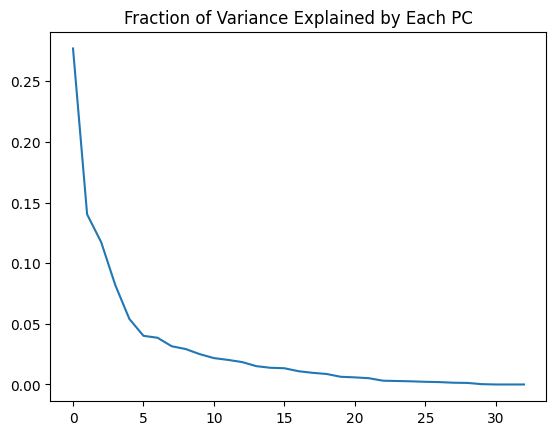

In [12]:
# Print variance expained and componenets of first PCs
plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_))
plt.title('Fraction of Variance Explained by Each PC')
keys = list(new_data.keys())
for i in range(6):
    print('PC ' + str(i))
    pc = pca.components_[i, :]
    for j in range(len(pc)):
        print(keys[j] + ': ' + str(pc[j]))
    

# Clustering

In [47]:
def plot_clusters(centers, keys, cluster_method = 'METHOD', xkey = 'LON_NUM', xstring = '', ykey = 'LAT_NUM', ystring = '', sizekey = None, sizestring = 'XX', shapekey = None, shapestring = 'XX', colorkey = None, colorstring = 'XX', fill_cmap = 'viridis', edgekey = None, edgestring = 'XX', edge_cmap = 'viridis', save = False, show = True, save_location = 'plots/clustering/'):
    fig=plt.figure(figsize=(15,6))
    plt.style.use('dark_background')
    is_map = xkey == 'LON_NUM' and ykey == 'LAT_NUM'
    if is_map:
        ax = plt.axes(projection = cp.crs.LambertConformal())
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)
        transform = cp.crs.PlateCarree()
    else:
        ax = plt.axes()
        transform = None

    lats = np.empty(centers.shape[0])
    lons = np.empty(centers.shape[0])
    sizes = np.empty(centers.shape[0]) # pick a scale
    shapes = np.empty(centers.shape[0]) # will do pointier for higher numbers
    colors = np.empty(centers.shape[0]) # pick a scale
    edges = np.empty(centers.shape[0]) # pick a scale

    for i in range(centers.shape[0]):
        center = centers[i, :]
        for j in range(len(center)):
            keyj = keys[j]
            centerj = center[j]
            #print(keyj + ': ' + str(centerj))
            if keyj == ykey:
                lats[i] = centerj
            elif keyj == xkey:
                lons[i] = centerj
            elif keyj == sizekey:
                sizes[i] = centerj
            elif keyj == shapekey:
                shapes[i] = centerj
            elif keyj == colorkey:
                colors[i] = centerj
            elif keyj == edgekey:
                edges[i] = centerj

    # PLOTTING    

    # Dynamic binning for shapes
    num_bins = 5  # Number of shapes
    bins = np.linspace(min(shapes), max(shapes), num_bins)  # Corrected binning
    shape_dict = {0: 'o', 1: 'H', 2: 's', 3: 'P', 4: '*'}  # Circle, Square, Diamond, Triangle

    # Bin the shapes variable
    shape_bins = np.digitize(shapes, bins) - 1  # -1 to match dictionary keys

    # Normalize colors and edge colors
    norm_colors = plt.Normalize(vmin=min(colors), vmax=max(colors))
    norm_edge_colors = plt.Normalize(vmin=min(edges), vmax=(max(edges)))

    # Convert to RGBA using colormap
    colors_rgba = plt.cm.get_cmap(fill_cmap)(norm_colors(colors))
    edge_colors_rgba = plt.cm.get_cmap(edge_cmap)(norm_edge_colors(edges))

    # Plot each shape separately based on the binned shapes
    for bin_idx in np.unique(shape_bins):
        ix = shape_bins == bin_idx
        if is_map:
            ax.scatter(
                lons[ix], lats[ix], 
                s=sizes[ix], 
                c=colors[ix], 
                edgecolor=edge_colors_rgba[ix],  # Use RGBA colors for edge colors
                linewidth=3,  
                marker=shape_dict[bin_idx], 
                cmap=fill_cmap, 
                transform=transform,
                alpha=1
            )
        else:
            ax.scatter(
                lons[ix], lats[ix], 
                s=sizes[ix], 
                c=colors[ix], 
                edgecolor=edge_colors_rgba[ix],  # Use RGBA colors for edge colors
                linewidth=3,  
                marker=shape_dict[bin_idx], 
                cmap=fill_cmap,
                alpha=1
            )

    # put numbers on top
    for i, (xi, yi) in enumerate(zip(lons, lats)):
        if is_map:
            ax.scatter(xi, yi, marker=f"${i}$", s=60, c = 'white', transform = transform)
        else: 
            ax.scatter(xi, yi, marker=f"${i}$", s=60, c = 'white')

    if is_map:
        ax.set_xlim(-2400000, 2300000)
        ax.set_ylim(-1700000, 1800000)
    else:
        xbuf = (max(lons) - min(lons))/10
        ybuf = (max(lats) - min(lats))/10
        ax.set_xlim(min(lons) - xbuf, max(lons) + xbuf)
        ax.set_ylim(min(lats) - ybuf, max(lats) + ybuf)

    # Add the first colorbar for internal colors
    cbar1 = plt.colorbar(ax.collections[0], ax=ax)
    cbar1.set_label(colorstring + ' (Fill)')

    # Create a dummy scatter plot for the edge colors colorbar
    scatter_dummy = ax.scatter(
        [], [], c=[], edgecolor=edge_colors_rgba, cmap=edge_cmap, alpha=1
    )

    # Add the second colorbar for edge colors
    cbar2 = plt.colorbar(scatter_dummy, ax=ax)
    cbar2.set_label(edgestring + ' (Edge)')

    # Dynamic size legend with gray points only
    unique_sizes = np.percentile(sizes, [10, 30, 50, 70, 90])
    for size in unique_sizes:
        plt.scatter([], [], s=size, color='gray', label=f'{int(size)} ' + sizestring, edgecolor='gray')

    # Dynamic shape legend with gray shapes only
    for bin_idx, shape in shape_dict.items():
        plt.scatter([], [], marker=shape, color='gray', label=f'{bins[bin_idx]:.3} ' + shapestring, edgecolor='gray')

    # Combine size and shape legends into one and position it further to the right of the colorbars
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.6, 0.5), title="Size & Shape Legend", frameon=False)

    plt.title('Cluster Centers with ' + cluster_method)
    if not is_map:
        plt.xlabel(xstring)
        plt.ylabel(ystring)
    
    if save:
        if is_map:
            plt.savefig(save_location + cluster_method + '/clusters.png')
        else:
            plt.savefig(save_location + cluster_method + '/' + xkey + ykey + '_clusters.png')
    if not show:
        plt.close()
    else:
        plt.show()

In [48]:
# cluster with, k-means, knn, optics, birch, dbscan look here for use cases https://scikit-learn.org/stable/modules/clustering.html
# Will want to come up with way to visualize: put location on map, color code by other value(s)? Then do similar for many clustering methods

save = True

# Define constants for plots
sizekey='REPORT_NUM'
sizestring = 'Total Reports'
colorkey= 'NEIGH_NUM'
colorstring = 'Neighborhood Brier Score'
fill_cmap = 'turbo'
shapekey = 'TOR_F'
shapestring = 'Max Tornado Rating'
edgekey = 'SEASON'
edgestring = 'Season'
edge_cmap = 'gist_earth'



clustering_algorithms = {
    'KMeans': KMeans,
    'OPTICS': OPTICS,
    #'DBSCAN': DBSCAN,
    'AgglomerativeClustering': AgglomerativeClustering,
    'MeanShift': MeanShift,
    'Birch': Birch,
    'SpectralClustering': SpectralClustering
}


# Cluster by one or two characteristics, show all characteristics

In [15]:
def cluster_partial(dataset, cluster_vars, clustering_algorithms):
    # clusters data in given variables and returns dictionary (by cluster method) of lists of datasets of points in each cluster
    new_data, means, stds = standardize_dataset(dataset)
    
    ret = {key: [] for key in clustering_algorithms}

    X = new_data[cluster_vars].to_array(dim = 'time').data.T
    for name, cls in clustering_algorithms.items():
        print(name)
        datasets = []
        labels = cls().fit_predict(X)
        for cluster_num in set(labels):
            datasets.append(dataset.sel(time=dataset['time'][labels == cluster_num]))
        ret[name] = datasets
    return(ret)


In [16]:
unstandardized_data = data.sel(time = pph_dates)
unstandardized_data = unstandardized_data.where(unstandardized_data['MAX_CAT'] >= 4, drop = True)



In [44]:
category_plot_dict = {
    '-1.0': -1,
    '0.0': 0,
    '1.0': 1,
    '2.0': 2,
    '3.0': 3,
    '4.0': 4,
    '5.0': 5
}

season_plot_dict = {
    '0.0': 0,
    '1.0': 1,
    '2.0': 2,
    '3.0': 3
}

ramp_up_plot_dict = {
    '0.0': 0,
    '1.0': 1,
    '2.0': 2,
    '3.0': 3,
    '4.0': 4,
    '5.0': 5,
    '6.0': 6
}

ramp_down_plot_dict = {
    '0.0': 0,
    '-1.0': 1,
    '-2.0': 2,
    '-3.0': 3,
    '-4.0': 4,
    '-5.0': 5,
    '-6.0': 6
}

tor_plot_dict = {
    '-1.0': -1,
    '0.0': 0,
    '1.0': 1,
    '2.0': 2,
    '3.0': 3,
    '4.0': 4,
    '5.0': 5,
    '6.0': 6
}


written_labels = ['Categorical Risk', 'Ramp Up', 'Ramp Down', 'Season',
                  'Total Storm Reports', 'Tornado Reports', 'Wind Reports', 'Hail Reports',
                  'Max Tornado Rating', 'Max Wind Speed (kt)', 'Max Hail Size (in)',
                  'Neighborhood Brier Score', 'RMSE', 'Brier Score',
                  'Max PPH',
                  'POD', 'FAR',
                  'Hail POD', 'Hail FAR',
                  'Wind POD', 'Wind FAR',
                  'Tornado POD', 'Tornado FAR',
                  'FARate', 'Hail FARate', 'Wind FARate', 'Tornado FARate']
graphing_dicts = [category_plot_dict, ramp_up_plot_dict, ramp_down_plot_dict, season_plot_dict, 
                  None, None, None, None, 
                  tor_plot_dict, None, None,
                  None, None, None,
                  None,
                  None, None,
                  None, None,
                  None, None,
                  None, None,
                  None, None, None, None]
steps = [1, 1, 1, 1,
         100, 25, 100, 50,
         1, 10, 1,
         .001, .01, .0025,
         10,
         .05, .1, 
         .05, .1,
         .05, .1,
         .05, .1, 
         .001, .001, .001, .001]

def plot_cluster_distribution(pph, label_1, label_2, label_1_string, label_2_string, dict_1, dict_2, titlestring, save_location, show=False, defaultbins = 10, step_1 = 1, step_2 = 1):
# plot 2d heatmap for any 2 labels

    data1 = []
    data2 = []

    for i in range(len(pph[label_1])):
        if dict_1 != None:
            data1.append(dict_1[str(pph[label_1].values[i])])
        else: 
            data1.append(pph[label_1].values[i])
        if dict_2 != None:
            data2.append(dict_2[str(pph[label_2].values[i])])
        else:
            data2.append(pph[label_2].values[i])

    
    if dict_1 != None:
        max1 = max(dict_1.values())
        min1 = min(dict_1.values())
        bins1 = np.linspace(min1-.5, max1+.5, 2+max1-min1)
        irange = bins1.size-1
    else:
        if ((max(data1) - min(data1))/step_1).is_integer():
            m = 2
        else: 
            m = 1
            
        bins1 = np.arange(step_1 * round(min(data1)/step_1), max(data1)+m*step_1, step_1)
        
        num_bins1 = len(bins1)-1
        irange = num_bins1

    if dict_2 != None:
        max2 = max(dict_2.values())
        min2 = min(dict_2.values())
        bins2 = np.linspace(min2-.5, max2+.5, 2+max2-min2)
        jrange = bins2.size-1
    else:
        if ((max(data2) - min(data2))/step_2).is_integer():
            m = 2
        else: 
            m = 1
        bins2 = np.insert(np.arange(step_2 * round(min(data2)/step_2), max(data2)+m*step_2, step_2), 0, 0)
        if isinstance(data2[1], numbers.Integral):
            bins2[1] = bins2[1] + 1
        else:
            bins2[1] = bins2[1] + .00000000001
        num_bins2 = len(bins2)-1
        jrange = num_bins2

    heatmap = np.histogram2d(data1, data2, bins = (bins1, bins2))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)

    for i in range(irange): 
        for j in range(jrange): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    if dict_1 != None:
        plt.yticks(range(len(list(dict_1.values()))), labels=list(dict_1.keys()))
    else:
        labels = [s for s in heatmap[1][range(num_bins1)].astype(str)]
        plt.yticks(range(num_bins1), labels = labels) 
        plt.yticks(fontsize=8)
    if dict_2 != None:
        plt.xticks(range(len(list(dict_2.values()))), labels=list(dict_2.keys()))
    else:
        labels = [s + '+' for s in heatmap[2][range(num_bins2)].astype(str)]
        labels[0] = '0'
        if isinstance(data2[1], numbers.Integral):
            labels[1] = '1+'
        else:
            labels[1] = '0+'
        plt.xticks(range(num_bins2), labels = labels)
        plt.xticks(fontsize=8)

    plt.ylabel(label_1_string)
    plt.xlabel(label_2_string)

    plt.title(label_2_string + ' by Cluster with ' + titlestring + ' Clustering')
    if save_location != None:
        plt.savefig(save_location + '/' + label_1_string + '_' + label_2_string + '_distribution.png')
    if show:
        plt.show()
    plt.close()

In [50]:
def summarize_clusters(d, savepath, scatter_nonmap = False,
                       showmap = True, savemap = True, 
                       xkey = 'LON_NUM', xstring = '', ykey = 'LAT_NUM', ystring = '', sizekey='REPORT_NUM', sizestring = 'Total Reports', colorkey= 'NEIGH_NUM', colorstring = 'Neighborhood Brier Score', fill_cmap = 'turbo', shapekey = 'TOR_F', shapestring = 'Max Tornado Rating', edgekey = 'SEASON', edgestring = 'Season', edge_cmap = 'gist_earth',
                       showgraph = True, savegraph = True, written_labels = written_labels, graphing_dicts = graphing_dicts, steps = steps,
                       showtext = True, savetext = True):
    
    
    for name in d.keys():
        print(name)
        datasets = d[name]

        if savemap or savegraph or savetext:
            if not os.path.exists(savepath + name):
                os.makedirs(savepath + name)
        
        keys = list(datasets[0].keys())
        centers = np.empty((len(datasets), len(keys)))

        for dataset, i in zip(datasets, range(len(datasets))):
            center = dataset.to_array(dim = 'time').data.mean(axis = 1)
            centers[i, :] = center

        if showgraph or savegraph:
            # make graph: 2d heatmap, cluster number is one dimension and data variable is other dimension. Separate graph for each variable, so iterate over keys?
            # combine datasets into one dataset with cluster number as separate column
            indexed_datasets = []
            for i, ds in enumerate(datasets):
                # Add a new variable 'cluster' to record the index
                ds = ds.assign(cluster=i)
                indexed_datasets.append(ds)

            # Combine all datasets along the common dimension
            combined_dataset = xr.concat(indexed_datasets, dim='time')

            # call plot_distribution_2d
            if savegraph == False:
                sp = None
            else: 
                sp = savepath + name 

            plot_keys = keys.copy()
            removekeys = ['LAT_NUM', 'LON_NUM', 'HR_NUM', 'HR_H_NUM', 'HR_W_NUM', 'HR_T_NUM']
            for k in removekeys:
                plot_keys.remove(k)

            for i in range(len(plot_keys)):
                plot_cluster_distribution(combined_dataset, 'cluster', plot_keys[i], 'Cluster', written_labels[i], None, graphing_dicts[i], name, sp, show = showgraph, step_2 = steps[i])

        if showtext or savetext:
            result_string = ''
            for i in range(centers.shape[0]):
                result_string += '\nCluster ' + str(i) + ':'
                for j in range(centers.shape[1]):
                    result_string += '\n' + str(keys[j]) + ': ' + str(centers[i, j])
            
            if savetext:
                path = savepath+name
                if not os.path.exists(path):
                    os.makedirs(path)
                with open(savepath + name + '/centers.txt', "w") as file:
                    file.write(result_string)

            if showtext:
                print(result_string)

        if showmap or savemap:
            plot_clusters(centers, keys, save_location = savepath, save = savemap, show = showmap, cluster_method = name, sizekey = sizekey, sizestring = sizestring, colorkey = colorkey, colorstring = colorstring, fill_cmap = fill_cmap, shapekey = shapekey, shapestring = shapestring, edgekey = edgekey, edgestring = edgestring, edge_cmap = edge_cmap)
            if scatter_nonmap:
                plot_clusters(centers, keys, save_location = savepath,  save = savemap, show = showmap, cluster_method = name, xkey = xkey, xstring = xstring, ykey = ykey, ystring = ystring, sizekey = sizekey, sizestring = sizestring, colorkey = colorkey, colorstring = colorstring, fill_cmap = fill_cmap, shapekey = shapekey, shapestring = shapestring, edgekey = edgekey, edgestring = edgestring, edge_cmap = edge_cmap)



In [51]:
d = cluster_partial(unstandardized_data, ['LAT_NUM', 'LON_NUM'], clustering_algorithms)
summarize_clusters(d, 'plots/clustering/latlon/', showmap = False, showtext = False, showgraph=False)

d = cluster_partial(unstandardized_data, list(unstandardized_data.keys()), clustering_algorithms)
summarize_clusters(d, 'plots/clustering/full/', showmap = False, showtext = False, showgraph = False)

d = cluster_partial(unstandardized_data, ['NEIGH_NUM'], clustering_algorithms)
summarize_clusters(d, 'plots/clustering/nbs/', showmap = False, showtext = False, showgraph = False)

d = cluster_partial(unstandardized_data, ['PPH_D_NUM'], clustering_algorithms)
summarize_clusters(d, 'plots/clustering/pph/', showmap = False, showtext = False, showgraph = False)

d = cluster_partial(unstandardized_data, ['POD_NUM', 'FAR_NUM'], clustering_algorithms)
summarize_clusters(d, 'plots/clustering/podfar/', showmap = False, showtext = False, showgraph = False, scatter_nonmap= True, xkey = 'POD_NUM', ykey = 'FAR_NUM', xstring = 'POD', ystring = 'FAR')

KMeans
OPTICS


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS
AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS
AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS
AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS
AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AgglomerativeClustering
MeanShift
Birch
SpectralClustering
KMeans
OPTICS
AgglomerativeClustering
MeanShift
Birch
SpectralClustering


In [35]:
list(pph.keys())

['lat',
 'lon',
 'p_perfect_wind',
 'p_perfect_sig_wind',
 'p_perfect_hail',
 'p_perfect_sig_hail',
 'p_perfect_tor',
 'p_perfect_sig_tor',
 'MAX_CAT',
 'RAMP_UP',
 'RAMP_DOWN',
 'RAMP_CAT',
 'SEASON',
 'p_perfect_total',
 'REGION',
 'PPH_CAT',
 'PPH_NUM',
 'REPORT_NUM',
 'TOR_NUM',
 'WIND_NUM',
 'HAIL_NUM',
 'TOR_F',
 'WINDSP_CAT',
 'WINDSP_NUM',
 'HAILSZ_CAT',
 'HAILSZ_NUM',
 'NEIGH_NUM',
 'RMSE_NUM',
 'BS_NUM',
 'p_perfect_max',
 'REGION_M',
 'LAT_NUM',
 'LON_NUM',
 'PPH_D_CAT',
 'PPH_D_NUM',
 'POD_NUM',
 'FAR_NUM',
 'POD_H_NUM',
 'FAR_H_NUM',
 'POD_W_NUM',
 'FAR_W_NUM',
 'POD_T_NUM',
 'FAR_T_NUM',
 'FART_NUM',
 'HR_NUM',
 'FART_H_NUM',
 'HR_H_NUM',
 'FART_W_NUM',
 'HR_W_NUM',
 'FART_T_NUM',
 'HR_T_NUM']